# Pyomo Model of the Double Pipe Heat Exchanger

This is additional material regarding the modeling and analysis of the double pipe heat exchanger.

## Temperature Dependence Heat Transfer Coefficient

### Dittus-Boelter Equation

$$Nu = C\cdot Re^{4/5}\cdot Pr^{2/5}$$

The Prandtl number for water is a reasonably strong function of temperature over the operating range of this heat exchanger.

$$Pr = \frac{\mu c_p}{k}$$

where

$$
\begin{align*}
\mu & = \text{viscosity} & \frac{\text{kg}}{\text{m}\cdot\text{s}} \\
c_p & = \text{specific heat} & \frac{\text{J}}{\text{kg}\cdot\text{K}} \\
k & = \text{thermal conductivity} & \frac{\text{W}}{\text{m}\cdot\text{K}} \\
\end{align*}
$$

### Whitaker Correlation

From a meta-analysis of data for well developed turbulent flow in a pipe, Stephen Whitaker proposed a correlation

$$Nu = 0.015\ Re^{0.83} Pr^{0.42}(\mu_b/\mu_0)^{0.14}$$

where $b$ refers to the bulk liquid and $0$ to liquid at the wall surface. The reference temperature for computing material propoerties is bulk liquid.

$$
\begin{align*}
Nu & = \frac{h D}{k_b} \\
Re & = \frac{\rho <v_z>D}{\mu_b} = \frac{\rho\dot{q}D}{\mu_b A_c}\\
Pr & = \frac{c_p \mu_b}{k_b} \\
\end{align*}
$$

where $h$ is the local heat transfer coefficient corresponding to $U$ in these notes. $D$ denotes hydraulic diameter, and $A_p$ is the cross-sectional area ($A_p = \frac{\pi D_H^2}{4}$). 


For water in the temperature range of interest, both $\rho$ and $c_p$ are weak functions of temperature.
Therefore we write a correlation for $U$ as

$$
\begin{align*}
U & = C\ k_b (\frac{\dot{q}}{\mu_b})^{0.83}(\frac{\mu_b}{k_b})^{0.42}(\frac{\mu_b}{\mu_0})^{0.14} \\
\\
\implies U & = C\ \dot{q}^{0.83}\frac{k_b^{0.58}}{\mu_b^{0.27}\mu_o^{0.14}}
\end{align*}
$$

where $C$ is treated as a constant

$$C = 0.015\ \frac{1}{D} \left(\frac{\rho D}{A_c}\right)^{0.83} (c_p)^{0.42} $$

## Colburn's Analogy

Colburn's analogy between momentum and heat transfer in turbulent flow yields a correlation

$$Nu = 0.023\ Re^{4/5} Pr^{1/3}$$

where properties are evaluated at the bulk flow temperature.

$$\frac{h D}{k_b} = 0.023\ \left(\frac{\rho \dot{q} D}{\mu_b A_c}\right)^{4/5} \left(\frac{c_p\mu_b}{k_b}\right)^{1/3}$$

$$h = 0.023\ \frac{k_b}{D} \left(\frac{\rho \dot{q} D}{\mu_b A_c}\right)^{4/5} \left(\frac{c_p\mu_b}{k_b}\right)^{1/3}$$

$$h =  
\underbrace{0.023\ \frac{1}{D} \left(\frac{\rho D}{A_c}\right)^{4/5} c_p^{1/3}}_{\text{constant }C}
\quad
\underbrace{\dot{q}^{4/5}}_{\text{flow rate}}
\quad
\underbrace{\frac{k_b^{2/3}}{ \mu_b^{7/15}}}_{\text{temperature dependent}}$$

### Physical property equations from

Pátek, J., Hrubý, J., Klomfar, J., Součková, M., & Harvey, A. H. (2009). Reference correlations for thermophysical properties of liquid water at 0.1 MPa. Journal of Physical and Chemical Reference Data, 38(1), 21-29. https://aip.scitation.org/doi/10.1063/1.3043575

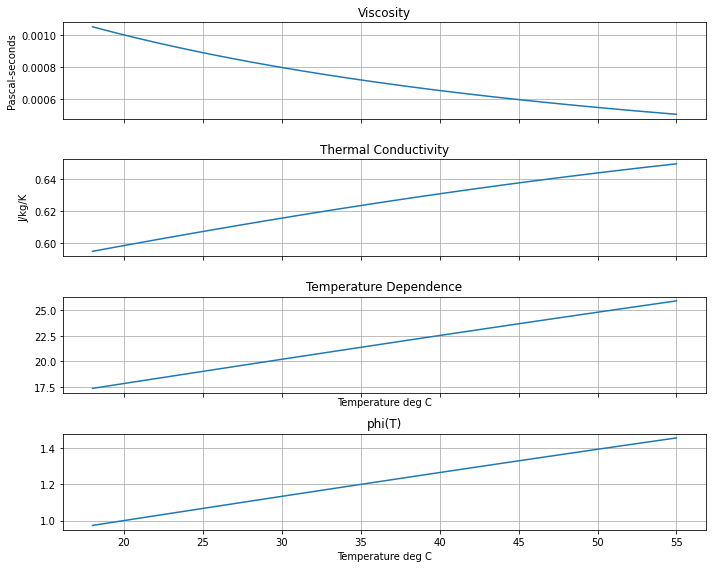

In [22]:
## import numpy as np
import math
import matplotlib.pyplot as plt

cp = 4183.0 # J/kg/K

def viscosity(T):
    ac = [280.68, 511.45, 61.131, 0.45903]
    bc = [-1.9, -7.7, -19.6, -40.0]
    Tr = (T + 273.15)/300
    return 1e-6*sum(a*Tr**b for a, b in zip(ac, bc))

def thermal_conductivity(T):
    Tr = (T + 273.15)/300
    cc = [0.80201, -0.25992, 0.10024, -0.032005]
    dc = [-0.32, -5.7, -12.0, -15.0]
    return sum(c*Tr**d for c, d in zip(cc, dc))

def temperature_dependence(T_centigrade):
    return thermal_conductivity(T_centigrade)**(2/3) * viscosity(T_centigrade)**(-7/15)

def phi(T_centigrade):
    return temperature_dependence(T_centigrade)/temperature_dependence(20)


T = np.linspace(18, 55)
fig, ax = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

ax[0].plot(T, list(map(viscosity, T)))
ax[0].set_title("Viscosity")
ax[0].set_ylabel("Pascal-seconds")
ax[0].grid(True)

ax[1].plot(T, list(map(thermal_conductivity, T)))
ax[1].set_title("Thermal Conductivity")
ax[1].set_ylabel("J/kg/K")
ax[1].grid(True)

ax[2].plot(T, list(map(temperature_dependence, T)))
ax[2].set_title("Temperature Dependence")
ax[2].set_xlabel("Temperature deg C")
ax[2].grid(True)

ax[3].plot(T, list(map(phi, T)))
ax[3].set_title("phi(T)")
ax[3].set_xlabel("Temperature deg C")
ax[3].grid(True)

plt.tight_layout()

## Pyomo DAE Model for Double Pipe Heat Exchanger

Let $y$ be a binar indicator variable

$$
y = \begin{cases}
0 & \text{counter-current flow} \\
1 & \text{co-current flow} \\
\end{cases}
$$

A model for the double-pipe heat exchanger is given by

$$
\begin{align*}
\rho_h\dot{q}_hC_{p,h} \frac{dT_h}{dz} & = (-1)^y U_hA(T_h - T_w)  & T_h(z=1-y) = T_{h,feed}\\
\rho_c\dot{q}_cC_{p,c} \frac{dT_c}{dz} & = U_cA(T_w - T_c) & T_c(z=0) = T_{c, feed} \\
\\
U_h (T_h - T_w) & = U_c (T_w - T_c) \\
\end{align*}
$$

where $T_w$ is the intermediate wall temperature, and where $U_h$ and $U_c$ are temperature dependent heat transfer coefficients determined by the temperatures in the bulk hot and cold fluids, respectively. Experiments have demonstrated the heat transfer resistance of the tube wall is negligible compared to the heat transfer resistances in the bulk flow.

From the Colburn analogy, we assume

$$
\begin{align*}
U_h & = C_h' \dot{q}_h^{4/5} F(T_h)\\
U_c & = C_c' \dot{q}_c^{4/5} F(T_c)\\
\end{align*}
$$

where $F(T)$ is the temperature dependent function of thermal conductivity and viscosity, and

$$F(T) =  \frac{k_b(T)^{2/3}}{ \mu_b(T)^{7/15}} $$

Two parameters, $C_h'$ and $C_c'$ are needed to because of the different pipe geometries for the hot and cold streams.  

$$
\begin{align*}
U_h & = C_h\dot{q}_h^{4/5} \phi(T_h)\\
U_c & = C_c \dot{q}_c^{4/5} \phi(T_c)\\
\end{align*}
$$

Parameter $C_h = C_h'F(T_0)$ and $C_c = C_c'F(T_0)$ will be determined by parameter estimation from experimental data. The normalization function

$$\phi(T) = F(T)/F(T_0)$$

is used to normalize $C_h'$ and $C_c'$. The normalized parameters $C_h$ and $C_c$ would be the heat transfer coefficients at a reference flow of 1 liter/sec and a reference temperature $T_0 = 20$ deg C.


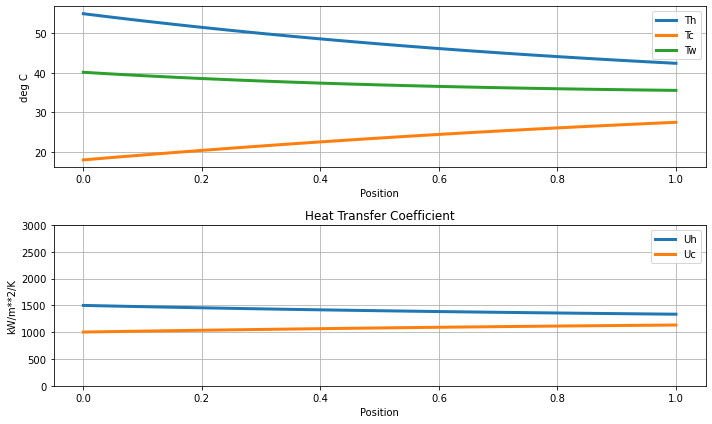

In [77]:
import pyomo.environ as pyo
import pyomo.dae as dae
import pandas as pd 
import matplotlib.pyplot as plt

def build_hx(config="co-current", qh=600, qc=600, Th_feed=55.0, Tc_feed=18.0):
    """
        Parameters:
            config (string): "co-current" or "counter-current"
            qh (float): hot water flowrate in liters/hour
            qc (float): cold water flowrate in liters/hour
            Th_feed (float): hot water feed temperature in C
            Tc_feed (float): cold water feed temperature in C

            
        Returns a Pyomo model:
            m.z: set of positions, 0 to 1.
            m.Th[z]: hot water temperature profile
            m.Tc[z]: cold water temperature profile
    """
    
    assert config in ["co-current", "counter-current"], "Unrecognized flow configuration"
    y_config = 1 if config=="co-current" else 0

    # known parameter values
    A = 0.5       # square meters
    Cp = 4184     # Joules/kg/deg C    
    rho = 1.0     # 1 kg/liter

    m = pyo.ConcreteModel()
    
    # estimated model parameters
    m.Ch = pyo.Param(mutable=True, default=5000.0)
    m.Cc = pyo.Param(mutable=True, default=5000.0)
    
    m.qh = pyo.Param(mutable=True, initialize=qh)
    m.qc = pyo.Param(mutable=True, initialize=qc)

    m.z = dae.ContinuousSet(bounds=(0, 1))

    m.Th = pyo.Var(m.z, initialize=Th_feed)
    m.Tc = pyo.Var(m.z, initialize=Tc_feed)
    m.Tw = pyo.Var(m.z, initialize=(Th_feed + Tc_feed)/2)
    m.Uh = pyo.Var(m.z, initialize=1500)
    m.Uc = pyo.Var(m.z, initialize=1500)
    
    m.dTh = dae.DerivativeVar(m.Th, wrt=m.z)
    m.dTc = dae.DerivativeVar(m.Tc, wrt=m.z)
    
    # feed conditions
    m.Th[1 - y_config].fix(Th_feed)
    m.Tc[0].fix(Tc_feed) 
    
    # local heat transfer coefficients
    @m.Constraint(m.z)
    def heat_transfer_ho(m, z):
        return m.Uh[z] == m.Ch * (m.qh/3600)**0.8 * phi(m.Th[z])
    
    @m.Constraint(m.z)
    def heat_transfer_cold(m, z):
        return m.Uc[z] == m.Cc * (m.qc/3600)**0.8 * phi(m.Tc[z])

    # stream energy balances
    @m.Constraint(m.z)
    def dThdz(m, z):
        return rho*Cp*(m.qh/3600)*m.dTh[z] == (-1)**y_config * m.Uh[z]*A*(m.Th[z] - m.Tw[z])

    @m.Constraint(m.z)
    def dTcdz(m, z):
        return rho*Cp*(m.qc/3600)*m.dTc[z] == m.Uc[z]*A*(m.Th[z] - m.Tw[z])
    
    # wall energy balance
    @m.Constraint(m.z)
    def wall(m, z):
        return m.Uh[z]*(m.Th[z] - m.Tw[z]) == m.Uc[z]*(m.Tw[z] - m.Tc[z])

    pyo.TransformationFactory('dae.finite_difference').apply_to(m, nfe=20, wrt=m.z)
    return m

def solve_hx(m):
    pyo.SolverFactory('ipopt').solve(m)

def visualize_hx(m):
    df = pd.DataFrame({
        "Th": [model.Th[z]() for z in model.z],
        "Tw": [model.Tw[z]() for z in model.z],
        "Tc": [model.Tc[z]() for z in model.z],
        "Uh": [model.Uh[z]() for z in model.z],
        "Uc": [model.Uc[z]() for z in model.z],
    }, index=model.z)
    fig, ax = plt.subplots(2, 1, figsize=(10, 6))
    df.plot(y=["Th", "Tc", "Tw"], ax=ax[0], grid=True, lw=3, ylabel="deg C", xlabel="Position")
    df.plot(y=["Uh", "Uc"], ax=ax[1], grid=True, ylim=(0, 3000), lw=3, 
            title="Heat Transfer Coefficient", ylabel="kW/m**2/K", xlabel="Position")
    plt.tight_layout()
    
model = build_hx("co-current", qc=500, qh=500)
solve_hx(model)
visualize_hx(model)


## Parameter Estimation

The model is parameterized by two coefficients $C_h$ and $C_c$ in the heat transfer model. The goal for parameter estimation is to find a values for $C_h$ and $C_c$ that fit the model over full operating range:

$$
\begin{align*}
&y \in [\text{co-current}, \text{counter-current}] \\
&\dot{q}_h^{min} \leq \dot{q}_h \leq \dot{q}_h^{max} \\
&\dot{q}_c^{min} \leq \dot{q}_c \leq \dot{q}_c^{max} \\
\end{align*}
$$

Operationally, the model wilk be used to determine the hot water flow necessary to temper the cold stream to a desired temperature at a desired flowrate. That is, given feed temperatures, flow configuration, desired cold stream flow and cold exit temperature, the model will be used to compute the required hot stream flowrate. The quality of the model will be measured by comparing the model's prediction for cold exit temperature to actual measurements.

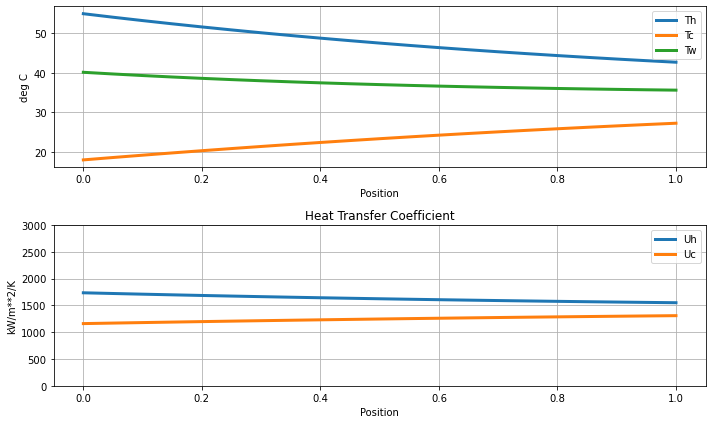

In [75]:
model = build_hx()
solve_hx(model)
visualize_hx(model)